In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import yfinance as yf
import seaborn as sb
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, SpatialDropout1D, Embedding, LSTM, GRU, Bidirectional, Dropout, Convolution1D,  ConvLSTM1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, MaxPooling1D

In [ ]:
import datetime
start= '2010-01-01'
end= '2019-12-31'
#dataset=yf.download('ETH-USD',start,end)
dataset=yf.download('ETH-USD',start,datetime.date.today())
#dataset=data.DataReader('TSLA', 'yahoo', start, datetime.date.today())
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [ ]:
dataset=dataset.reset_index()
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1916,2023-02-07,1616.009644,1673.797852,1614.863037,1672.003540,1672.003540,8030277434
1917,2023-02-08,1671.905273,1688.527222,1635.265015,1650.716797,1650.716797,7806089579
1918,2023-02-09,1651.082275,1655.234863,1537.182251,1546.438232,1546.438232,10524969124
1919,2023-02-10,1546.596558,1553.325684,1504.834473,1514.869141,1514.869141,8397387897


In [ ]:
dataset.shape

(1921, 7)

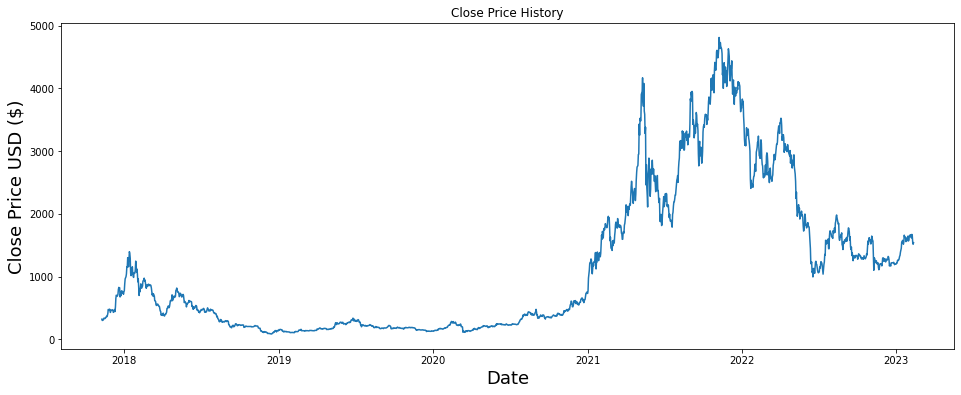

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(dataset['Date'],dataset['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
dataset = dataset.drop(['Adj Close'], axis=1)

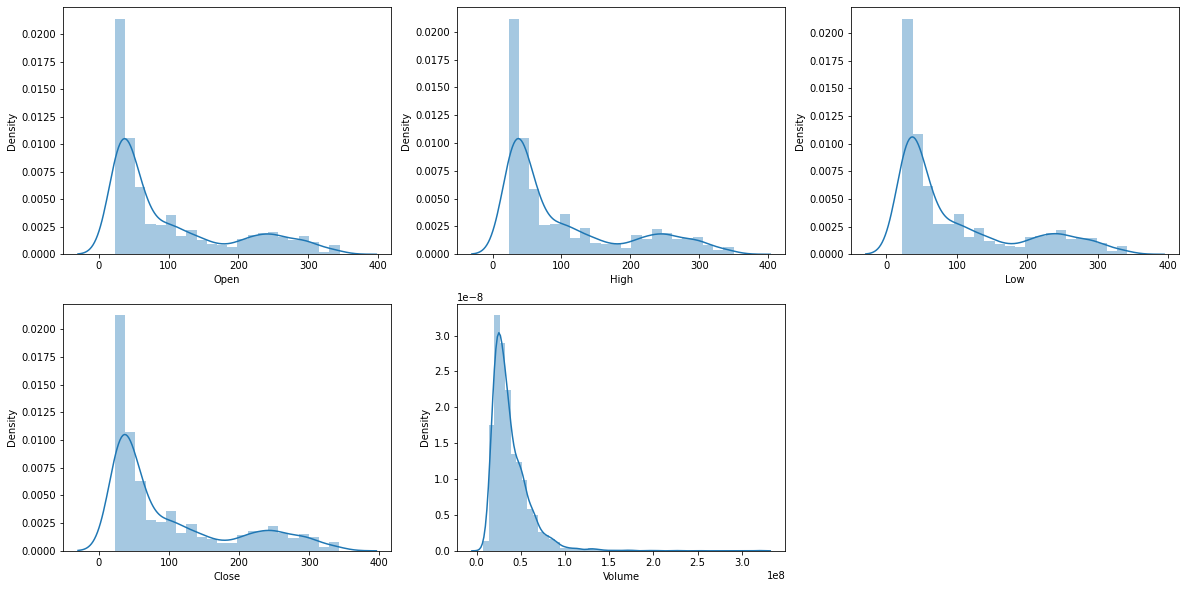

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(dataset[col])
plt.show()

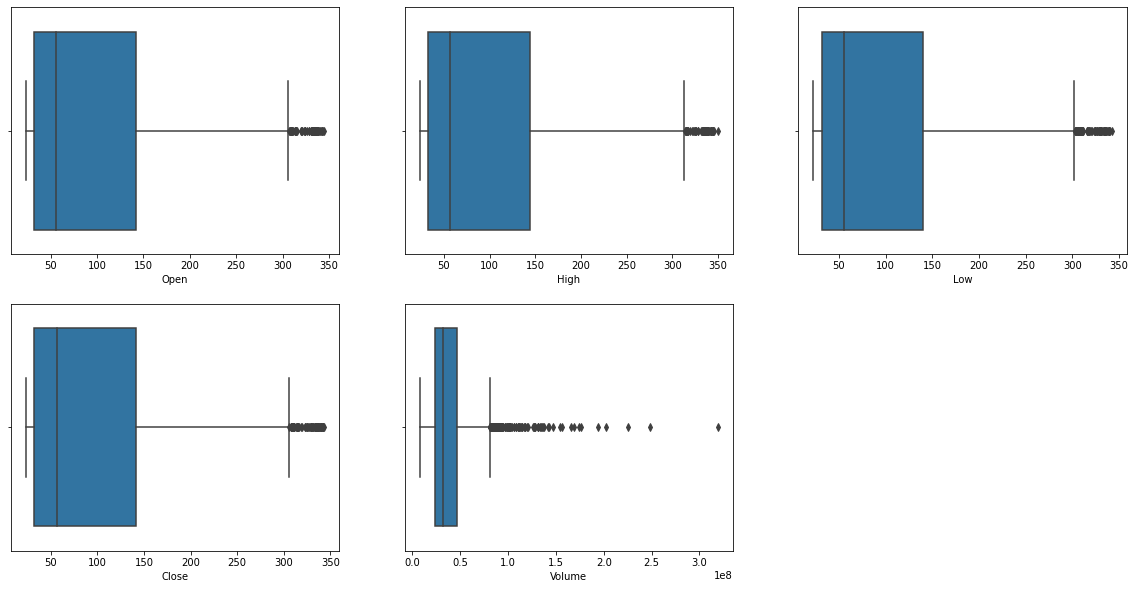

In [ ]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(dataset[col])
plt.show()

In [ ]:
#moving average (30 days)
ma30=dataset.Close.rolling(100).mean()
ma30

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3295    240.2967
3296    240.4501
3297    240.6636
3298    240.8524
3299    241.0382
Name: Close, Length: 3300, dtype: float64

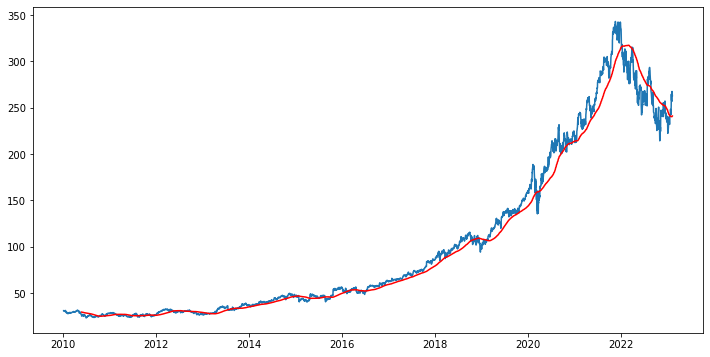

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dataset.Date,dataset.Close)
plt.plot(dataset.Date,ma30,'r')
plt.show()

In [ ]:
dataset = dataset.drop(['Date'], axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=scaler=MinMaxScaler(feature_range=(0,1))
#scaler=StandardScaler()

In [ ]:
train_data=pd.DataFrame(dataset['Close'][0:int(len(dataset)*.70)])
test_data=pd.DataFrame(dataset['Close'][int(len(dataset)*.70):int(len(dataset))])
print(train_data.shape,test_data.shape)

(1344, 1) (577, 1)


In [ ]:
time_step=100

In [ ]:
training_data=scaler.fit_transform(train_data)
training_data

array([[0.05792188],
       [0.05262586],
       [0.05640317],
       ...,
       [0.47801787],
       [0.45435778],
       [0.46763939]])

In [ ]:
training_data.shape

(1344, 1)

In [ ]:
past_time_index=train_data.tail(time_step)
final_test_data=past_time_index.append(test_data,ignore_index=True)

In [ ]:
testing_data=scaler.fit_transform(final_test_data)

In [ ]:
training_data.shape,testing_data.shape

((1344, 1), (677, 1))

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset,time_step):
	dataX = []
	dataY = []
	time_step=100
	for i in range(time_step, dataset.shape[0]):
		dataX.append(dataset[i-time_step: i])
		dataY.append(dataset[i, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(training_data,100)
x_test, y_test = create_dataset(testing_data,100)

In [ ]:
x_train.shape,x_test.shape

((1244, 100, 1), (577, 100, 1))

In [ ]:
from sklearn import metrics
# Build the LSTM model
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dense(1))
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_8 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 60)           26640     
                                                                 
 dropout_9 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_10 (Dropout)        (None, 100, 80)           0         
                                                                 
 lstm_12 (LSTM)              (None, 120)              

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])

# Train the model
checkpointer = ModelCheckpoint(filepath="model2.h5", verbose=1, save_best_only=True, monitor='loss',mode='min')
model.fit(x_train, y_train, batch_size=32, epochs=30, callbacks=[checkpointer])

Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 0.0178 - mae: 0.0777
Epoch 1: loss improved from inf to 0.01776, saving model to model2.h5
39/39 [==============================] - 20s 354ms/step - loss: 0.0178 - mae: 0.0777
Epoch 2/30
39/39 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0326
Epoch 2: loss improved from 0.01776 to 0.00342, saving model to model2.h5
39/39 [==============================] - 14s 351ms/step - loss: 0.0034 - mae: 0.0326
Epoch 3/30
39/39 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0275
Epoch 3: loss improved from 0.00342 to 0.00292, saving model to model2.h5
39/39 [==============================] - 14s 350ms/step - loss: 0.0029 - mae: 0.0275
Epoch 4/30
39/39 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0271
Epoch 4: loss improved from 0.00292 to 0.00277, saving model to model2.h5
39/39 [==============================] - 14s 353ms/step - loss: 0.0028 - mae: 0.0271
Epoch 5/30
3

In [ ]:
model.save('model2.h5')

In [ ]:
x_test, y_test= np.array(x_test), np.array(y_test)
print(x_test.shape, y_test.shape)

(577, 100, 1) (577,)


In [ ]:
y_pred=model.predict(x_test)

19/19 [==============================] - 4s 144ms/step


In [ ]:
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_test)

In [ ]:
scale_factor=1/scaler.scale_
y_pred=y_pred * scale_factor
y_test=y_test * scale_factor

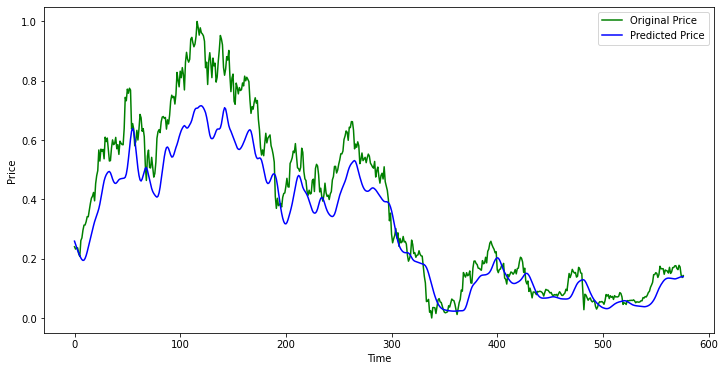

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'g', label ='Original Price')
plt.plot(y_pred,'blue', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import log


r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)

print("MSE :", mse)
print("MAE :" ,mae)
print("RMSE :" ,rmse)
print("R2_score :",r2)

MSE : 0.011837167807079914
MAE : 0.0824968882534655
RMSE : 0.10879874910622785
R2_score : 0.8446523543982698


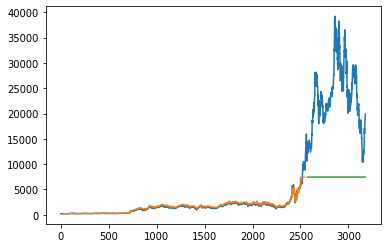

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()